This briefly shows how to work with geopandas and geoplot

In [2]:


%matplotlib inline

import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)


First read local shape data and filter for Sweden, 

In [3]:
world = gpd.read_file("data/ne_10m_admin_1_states_provinces.shp")
swe = world[world['admin'] == 'Sweden']  # Filter out Sweden from the world

Now read SMHI observations in geojson format, we can use wild card. 02* is a file with air temperature, average for 24 hours, see [here](https://www.viltstigen.se/smhi_metobs/). Show first rows of data.

In [4]:
avg_temp = gpd.read_file("https://www.viltstigen.se/metobs/latest/02*") # Probl in EPSG 3006 or 3021
avg_temp = avg_temp.to_crs(epsg=4326)
avg_temp.head()

,id,key,title,summary,updated,timestamp,height,value,geometry
0,Abisko Aut,02,Lufttemperatur,"medelvärde 1 dygn, 1 gång/dygn, kl 00",1755900000000,2025-08-22 22:00:00,392.235,6.7,POINT (18.8164 68.3538)
1,Abraur,02,Lufttemperatur,"medelvärde 1 dygn, 1 gång/dygn, kl 00",1755900000000,2025-08-22 22:00:00,368.079,8.7,POINT (18.9195 65.9857)
2,Adelsö A,02,Lufttemperatur,"medelvärde 1 dygn, 1 gång/dygn, kl 00",1755900000000,2025-08-22 22:00:00,5.612,12.3,POINT (17.5213 59.3579)
3,Arjeplog A,02,Lufttemperatur,"medelvärde 1 dygn, 1 gång/dygn, kl 00",1755900000000,2025-08-22 22:00:00,430.839,7.3,POINT (17.8396 66.0513)
4,Arvidsjaur A,02,Lufttemperatur,"medelvärde 1 dygn, 1 gång/dygn, kl 00",1755900000000,2025-08-22 22:00:00,382.450,8.1,POINT (19.2642 65.5941)


Now read another file, 09* is air pressure. Show first rows.

In [5]:
pressure = gpd.read_file("https://www.viltstigen.se/metobs/latest/09*")
pressure = pressure.to_crs(epsg=4326)
pressure.head()

,id,key,title,summary,updated,timestamp,height,value,geometry
0,Abisko Aut,09,Lufttryck reducerat havsytans nivå,"vid havsytans nivå, momentanvärde, 1 gång/tim",1755900000000,2025-08-22 22:00:00,392.235,1001.5,POINT (18.8164 68.3538)
1,Arjeplog A,09,Lufttryck reducerat havsytans nivå,"vid havsytans nivå, momentanvärde, 1 gång/tim",1755900000000,2025-08-22 22:00:00,430.839,1005.2,POINT (17.8396 66.0513)
2,Arvidsjaur A,09,Lufttryck reducerat havsytans nivå,"vid havsytans nivå, momentanvärde, 1 gång/tim",1755900000000,2025-08-22 22:00:00,382.450,1004.9,POINT (19.2642 65.5941)
3,Arvika A,09,Lufttryck reducerat havsytans nivå,"vid havsytans nivå, momentanvärde, 1 gång/tim",1755900000000,2025-08-22 22:00:00,65.758,1009.1,POINT (12.6354 59.6743)
4,Berga,09,Lufttryck reducerat havsytans nivå,"vid havsytans nivå, momentanvärde, 1 gång/tim",1755900000000,2025-08-22 22:00:00,4.300,1004.0,POINT (18.115 59.068)


Now plot data through a Python script

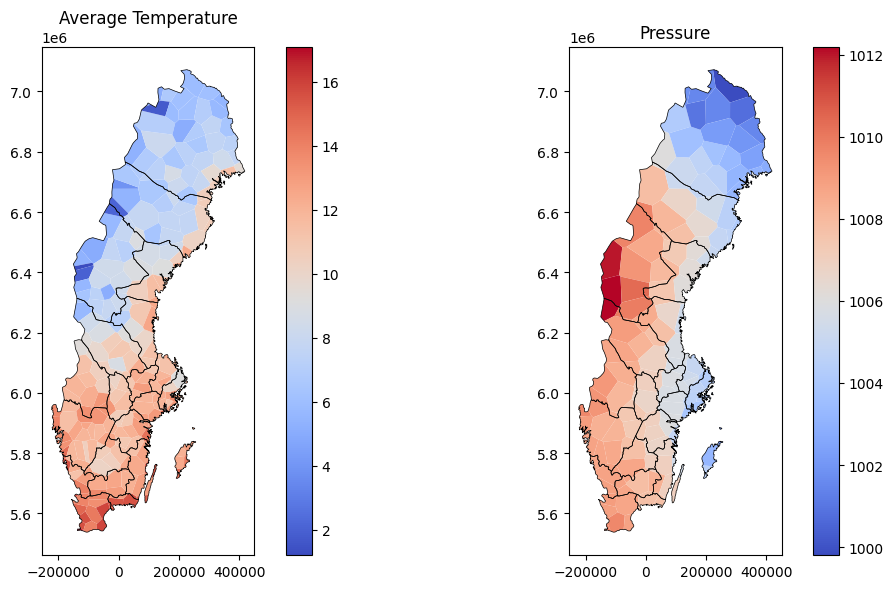

In [10]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, MultiPoint
from shapely.ops import voronoi_diagram
import pyproj

# --- Reproject data to Albers Equal Area ---
aea = pyproj.CRS.from_proj4(
    "+proj=aea +lat_1=55 +lat_2=65 +lat_0=0 +lon_0=15 "
    "+x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
)

avg_temp_proj = avg_temp.to_crs(aea)
pressure_proj = pressure.to_crs(aea)
swe_proj = swe.to_crs(aea)

# --- Function to compute Voronoi polygons from points and clip ---
def voronoi_gdf(points_gdf, clip_gdf):
    # Convert points to MultiPoint
    mp = MultiPoint(points_gdf.geometry.tolist())

    # Compute Voronoi polygons with envelope matching clip geometry
    vor = voronoi_diagram(mp, envelope=clip_gdf.union_all())

    # Convert to GeoDataFrame
    vor_polys = gpd.GeoDataFrame(geometry=[g for g in vor.geoms], crs=points_gdf.crs)

    # Clip polygons to clip_gdf
    vor_clipped = gpd.overlay(vor_polys, clip_gdf, how="intersection")

    # Assign nearest value from points
    vor_clipped = vor_clipped.sjoin_nearest(points_gdf[["value", "geometry"]])
    return vor_clipped

# --- Compute Voronoi for temperature and pressure ---
vor_temp = voronoi_gdf(avg_temp_proj, swe_proj)
vor_pressure = voronoi_gdf(pressure_proj, swe_proj)

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

vor_temp.plot(column="value", cmap="coolwarm", legend=True, ax=ax1)
swe_proj.boundary.plot(edgecolor="black", ax=ax1, linewidth=0.5)
ax1.set_title("Average Temperature")

vor_pressure.plot(column="value", cmap="coolwarm", legend=True, ax=ax2)
swe_proj.boundary.plot(edgecolor="black", ax=ax2, linewidth=0.5)
ax2.set_title("Pressure")

plt.tight_layout()
plt.show()

